# Convolutional Neural Network model for GTSRB (German Traffic Sign Recognition Benchmark)

In [1]:
# Importing the libraries

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
tf.__version__
np.random.seed(42)
import pathlib
import sys

In [2]:
# set working directory
path = pathlib.Path().absolute()
sys.path.append(path)
os.chdir(path)

# Path for dataset
train_path = 'dataset/Train'
test_path = 'dataset/Test'

In [3]:
# Finding total classes and review of labels
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


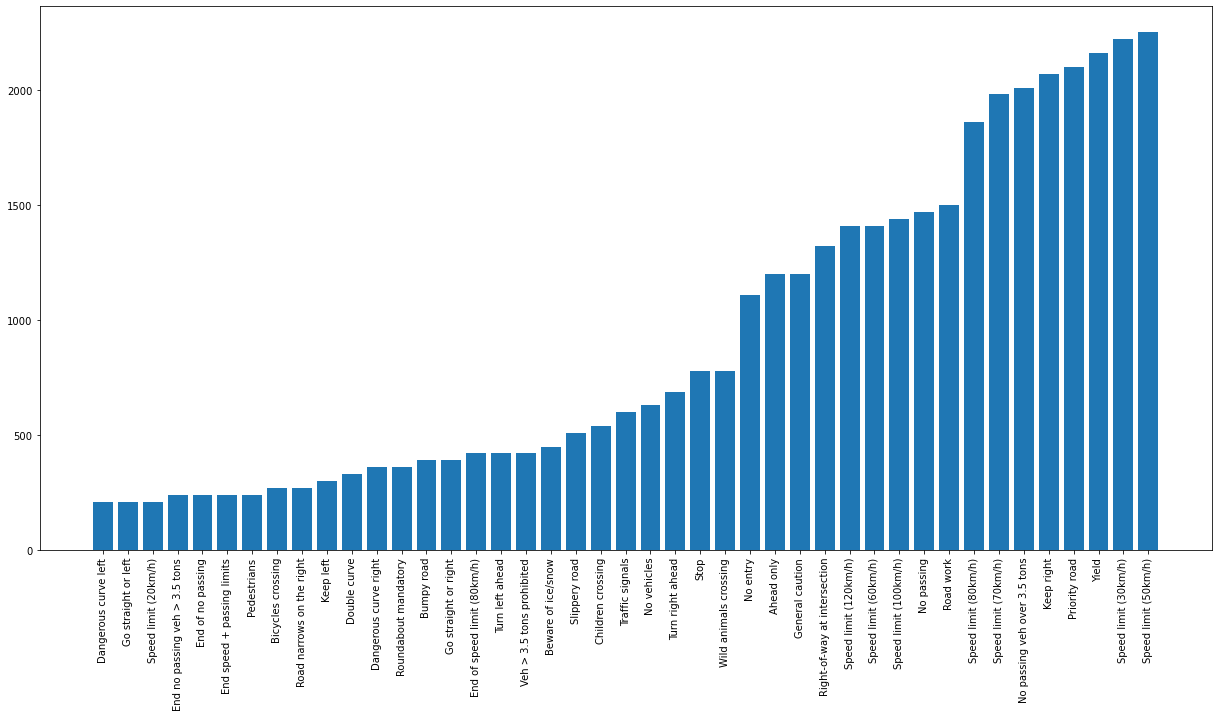

In [4]:
# Visualizing the dataset
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()


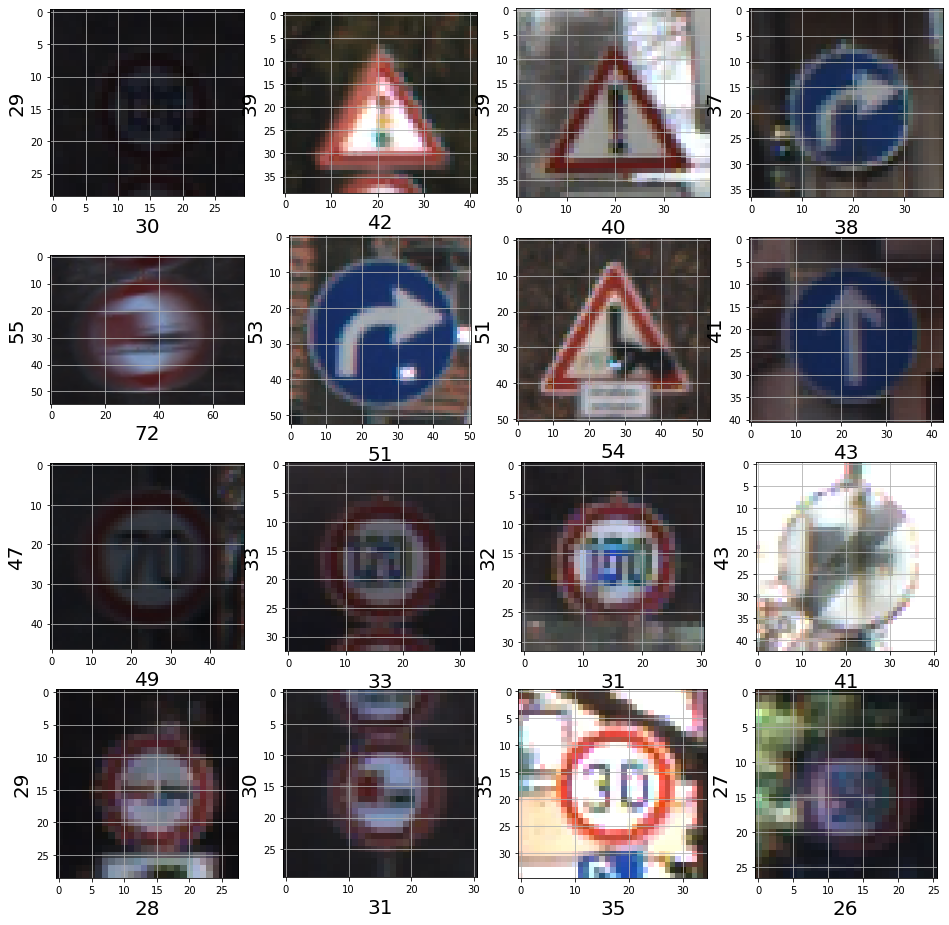

In [5]:
# Visualizing 16 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv('dataset/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(16,16))

for i in range(1,17):
    plt.subplot(4,4,i)
    random_img_path = 'dataset' + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20) # width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20) # height of image

# Preprocessing the Training data

In [6]:
# Collecting and Preprocessing the Training data

image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = 'dataset/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)            # Reads image as an 3D array (img_pixel val) across RGB
            image_fromarray = Image.fromarray(image, 'RGB') # Converts array to image type
            resize_image = image_fromarray.resize((30, 30)) # Resize to Target image size
            image_data.append(np.array(resize_image))       # Converts the resized image to array again and appends it to a list
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)


(39209, 30, 30, 3) (39209,)


In [7]:
# Shuffling the training data
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

# Splitting the data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255   # Normalize image data
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)


X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [8]:
# One hot encoding the labels
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)


(27446, 43)
(11763, 43)


# CNN Model

In [9]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[30, 30, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dropout(rate=0.2))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))


In [11]:
# Compiling the CNN
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Augmenting the data 
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")


# Training the model

In [12]:
# Training the CNN on the Training set and Validating on Validation Set
train_val_history = cnn.fit(aug.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_val, y_val))


Epoch 1/30
858/858 [==============================] - 20s 22ms/step - loss: 1.2307 - accuracy: 0.6525 - val_loss: 0.2375 - val_accuracy: 0.9312
Epoch 2/30
858/858 [==============================] - 19s 22ms/step - loss: 0.3818 - accuracy: 0.8850 - val_loss: 0.1176 - val_accuracy: 0.9667
Epoch 3/30
858/858 [==============================] - 19s 23ms/step - loss: 0.2411 - accuracy: 0.9265 - val_loss: 0.0784 - val_accuracy: 0.9775
Epoch 4/30
858/858 [==============================] - 19s 22ms/step - loss: 0.1771 - accuracy: 0.9449 - val_loss: 0.0574 - val_accuracy: 0.9839
Epoch 5/30
858/858 [==============================] - 20s 23ms/step - loss: 0.1483 - accuracy: 0.9546 - val_loss: 0.0444 - val_accuracy: 0.9879
Epoch 6/30
858/858 [==============================] - 19s 22ms/step - loss: 0.1231 - accuracy: 0.9610 - val_loss: 0.0349 - val_accuracy: 0.9901
Epoch 7/30
858/858 [==============================] - 18s 21ms/step - loss: 0.1036 - accuracy: 0.9676 - val_loss: 0.0216 - val_accuracy:

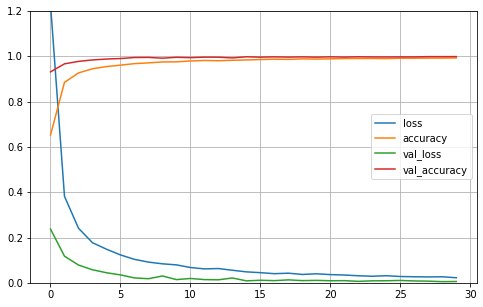

In [13]:
# Save the model
cnn.save("cnn.h5")
cnn.save_weights("./output")

# Evaluating the model
pd.DataFrame(train_val_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.show()


# Testing the model

In [14]:
# Loading the test data and running the predictions
test = pd.read_csv('dataset/Test.csv')

labels = test["ClassId"].values

# One hot encoding multi-class labels
y_test = keras.utils.to_categorical(labels, NUM_CATEGORIES)

imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread('dataset' + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        data.append(np.array(resize_image)) # List of 3D array (H x W x C)
    except:
        print("Error in " + img)
X_test = np.array(data)                     # Array of (no of elem x H x W x C)
X_test = X_test/255

pred = cnn.predict(X_test)

           
#Accuracy with the test data

print('Test Data accuracy: ',accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))


Test Data accuracy:  0.9642121931908155


# Performance report

<AxesSubplot:>

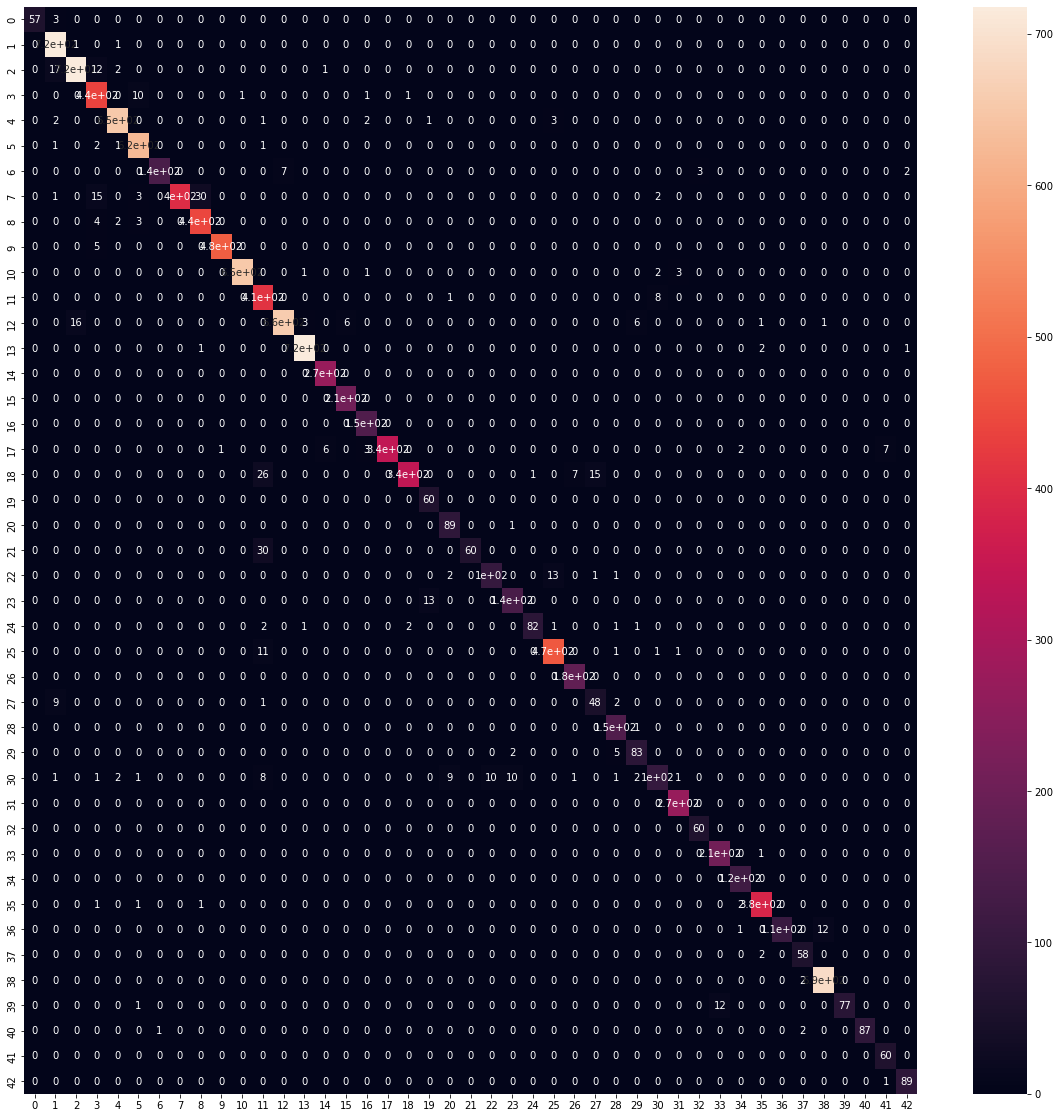

In [15]:
# Visualizing the confusion matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)) # argmax gives column index which has highest value

import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)


In [16]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        60
           1       0.95      1.00      0.98       720
           2       0.98      0.96      0.97       750
           3       0.92      0.97      0.94       450
           4       0.99      0.99      0.99       660
           5       0.97      0.99      0.98       630
           6       0.99      0.92      0.96       150
           7       1.00      0.89      0.94       450
           8       0.93      0.98      0.96       450
           9       1.00      0.99      0.99       480
          10       1.00      0.99      0.99       660
          11       0.84      0.98      0.90       420
          12       0.99      0.95      0.97       690
          13       0.99      0.99      0.99       720
          14       0.97      1.00      0.99       270
          15       0.97      1.00      0.99       210
          16       0.96      1.00      0.98       150
          17       1.00    

# Visualize the model performance

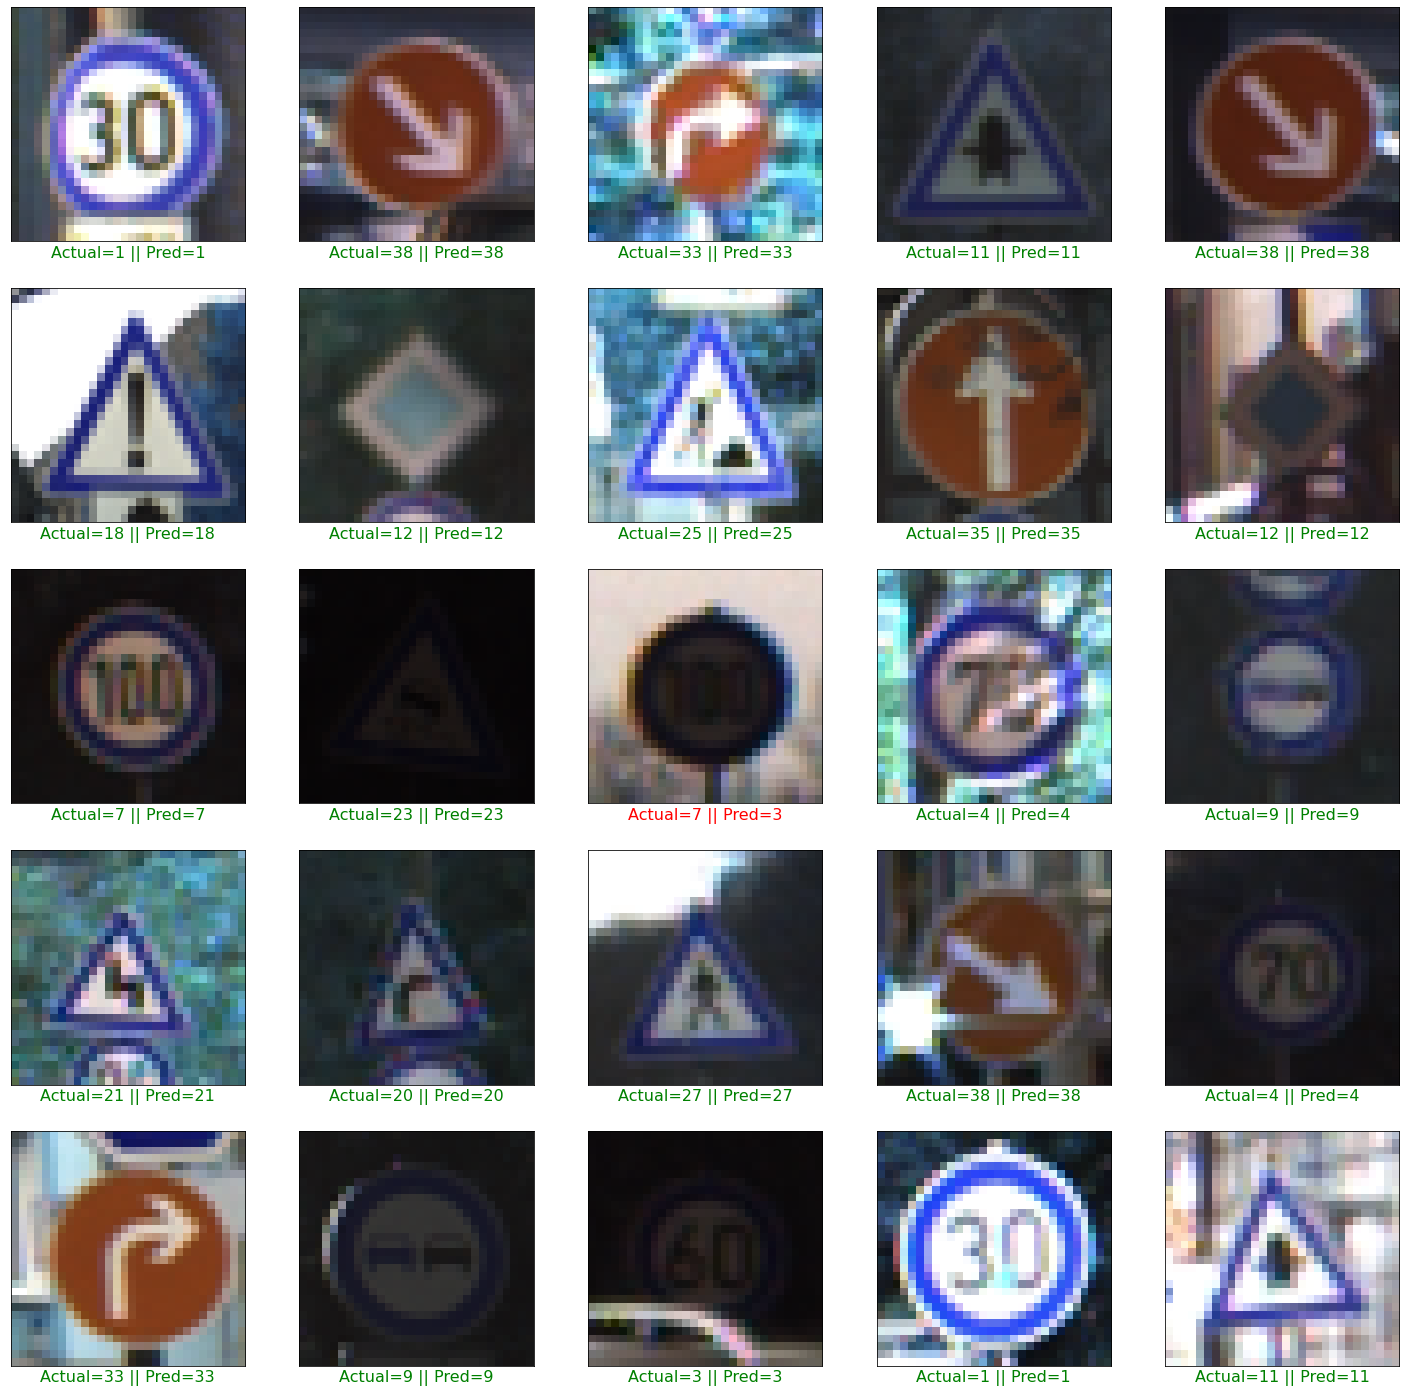

In [19]:
# Predictions on Test Data
plt.figure(figsize = (25, 25))

for i in range(1,26):
    plt.subplot(5, 5, i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred.argmax(axis=1)[i]
    actual = y_test.argmax(axis=1)[i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col, fontsize=16)
    plt.imshow(X_test[i])
plt.show()


# Test the model on a new single image

In [20]:
# Load the saved model
model_path = "cnn.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

# Single Prediction for future case
image = cv2.imread("dataset/Test/00000.png") # example of new image to be tested

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image,axis=0) # (1, 30, 30, 3)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
print(result,':', classes[int(result)])


16 : Veh > 3.5 tons prohibited


# The results obtained show that the model gives excellent predictions in recognition and classification of traffic sign images with an accuracy of 96.42% on the Test Data.